# OSCAR, a Tech Preview (Part I)

A tiny example of using polymake and GAP combined.

## The Setup

The configuration can be cloned via copying the <i>Project.toml</i> file and using <i>instantiate</i> in the REPL mode.

In [1]:
versioninfo()

using Pkg
Pkg.status()

Julia Version 1.3.1
Commit 2d5741174c (2019-12-30 21:36 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-6700K CPU @ 4.00GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, skylake)
    Status `/cache/polymake/oscar-system/oscar-notebooks/MPI-demo-200124/Project.toml`
  [c863536a] GAP v0.3.5
  [7073ff75] IJulia v1.21.1
  [f1435218] Oscar v0.2.0


## polymake's Functions Are Available

In [2]:
import Polymake

polymake version 4.0
Copyright (c) 1997-2020
Ewgenij Gawrilow, Michael Joswig, and the polymake team
Technische Universität Berlin, Germany
https://polymake.org

This is free software licensed under GPL; see the source for copying conditions.
There is NO warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In the context of Hilbert's 16th Problem Itenberg and Viro constructed a counter-example to a conjecture of Ragsdale, via <i>patchworking</i>.  This is just to show that (almost) all of polymake's functionality is available through Julia.

In [3]:
R = Polymake.tropical.ragsdale_counterexample();

polymake: used package ppl
  The Parma Polyhedra Library ([[wiki:external_software#PPL]]): A C++ library for convex polyhedra
  and other numerical abstractions.
  http://www.cs.unipr.it/ppl/



Interactive visualization is possible, also within a Jupyter notebook.  Yet, for static web versions svg output is nicer.

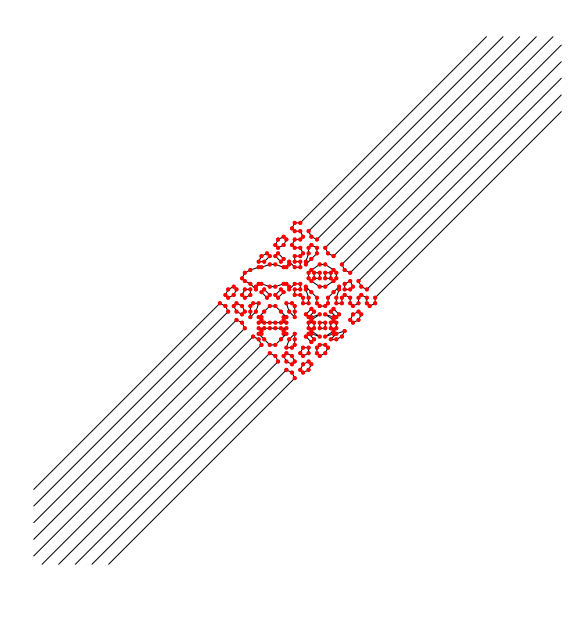

polymake: used package cdd
  cddlib
  Implementation of the double description method of Motzkin et al.
  Copyright by Komei Fukuda.
  http://www-oldurls.inf.ethz.ch/personal/fukudak/cdd_home/

polymake: used package SVG
   Generated using the Perl SVG Module
   by Ronan Oger



In [4]:
Polymake.display_svg(R)

The actual example starts here.  We construct a regular $4$-cube, with $\pm1$-coordinates, but the precise coordinates will not matter here.

In [5]:
C = Polymake.polytope.cube(4);

We can get the combinatorial automorphism group.  Julia issues a warning to indicate that some data obtained from polymake is opaque and cannot be accessed directly in a Julia-typical way.

In [6]:
G_polymake = Polymake.group.automorphism_group(C.VERTICES_IN_FACETS)

polymake: used package bliss
  [[wiki:external_software#bliss]] is a software for computation of automorphism groups of graphs.
  Copyright by Tommi Junttila and Petteri Kaski.
  http://www.tcs.hut.fi/Software/bliss/


type: Group

PERMUTATION_ACTION
	type: PermutationAction<Int, Rational>

From the type information output (which is suppressed by ";" following the command) we see that the group is given as a permutation group.  What is not obvious, but true: this is the natural action on the eight facets.

In [7]:
gens = G_polymake.PERMUTATION_ACTION.GENERATORS

pm::Array<pm::Array<long>>
0 1 2 3 6 7 4 5
0 1 4 5 2 3 6 7
2 3 0 1 4 5 6 7
1 0 2 3 4 5 6 7


Note that polymake is $0$-based, while Julia is $1$-based.

In [8]:
gens[2]

pm::Array<long>
0 1 4 5 2 3 6 7

Generic Julia functions can convert between $0$- and $1$-based containers.  Future Polymake.jl versions will have this built-in.

In [9]:
to_one_based_indexing(n::Number) = n + one(n)
to_zero_based_indexing(n::Number) = (n > zero(n) ? n - one(n) : throw(ArgumentError("Can't use negative index")))

for f in [:to_one_based_indexing, :to_zero_based_indexing]
    @eval begin
        $f(itr) = $f.(itr)
        $f(s::S) where S<:AbstractSet = S($f.(s))
    end
end

Applying this to the generators of the group computed by polymake yields a standard Julia datatype.

In [10]:
to_one_based_indexing(gens)

4-element Array{Array{Int64,1},1}:
 [1, 2, 3, 4, 7, 8, 5, 6]
 [1, 2, 5, 6, 3, 4, 7, 8]
 [3, 4, 1, 2, 5, 6, 7, 8]
 [2, 1, 3, 4, 5, 6, 7, 8]

## Use GAP For Groups

The software of choice to deal with groups is GAP.  Here is a micro-demo, which constructs a symmetric group of degree four from a 4-cycle and a transposition.

In [11]:
import GAP

S4 = GAP.Globals.Group(GAP.@gap [(1,2,3,4), (1,2)])
@show S4
GAP.Globals.Order(S4)

┌ Info: Precompiling GAP [c863536a-3901-11e9-33e7-d5cd0df7b904]
└ @ Base loading.jl:1273
ERROR: LoadError: could not open file /home/mic/.julia/packages/GAP/4od8v/deps/deps.jl
Stacktrace:
 [1] include at ./boot.jl:328 [inlined]
 [2] include_relative(::Module, ::String) at ./loading.jl:1105
 [3] include at ./Base.jl:31 [inlined]
 [4] include(::String) at /home/mic/.julia/packages/GAP/4od8v/src/GAP.jl:1
 [5] top-level scope at /home/mic/.julia/packages/GAP/4od8v/src/GAP.jl:6
 [6] include at ./boot.jl:328 [inlined]
 [7] include_relative(::Module, ::String) at ./loading.jl:1105
 [8] include(::Module, ::String) at ./Base.jl:31
 [9] top-level scope at none:2
 [10] eval at ./boot.jl:330 [inlined]
 [11] eval(::Expr) at ./client.jl:425
 [12] top-level scope at ./none:3
in expression starting at /home/mic/.julia/packages/GAP/4od8v/src/GAP.jl:6


ErrorException: Failed to precompile GAP [c863536a-3901-11e9-33e7-d5cd0df7b904] to /home/mic/.julia/compiled/v1.3/GAP/YqHod_JecgB.ji.

A typical OSCAR-function will provide natural ways of communication between the corner stone systems.  The function is fairly short, the bulk of the code are some straightforward conversions.

In [12]:
function combinatorial_automorphism_group(P)
    G = Polymake.Group.automorphism_group(P.VERTICES_IN_FACETS)
    gens_polymake = G.PERMUTATION_ACTION.GENERATORS # acting on the facets
    gens_julia = Vector{Int64}.(Polymake.to_one_based_indexing(gens_polymake))
    gens_gap = GAP.Globals.PermList.(GAP.julia_to_gap.(gens_julia))
    return GAP.Globals.Group(gens_gap...)
end

combinatorial_automorphism_group (generic function with 1 method)

Recognizing the isomorphism type of the (combinatorial) automorphism group of a polytope is available neither in GAP nor polymake alone.

In [13]:
G = combinatorial_automorphism_group(C)
GAP.Globals.StructureDescription(G)

┌ Warning: The return value contains pm::IncidenceMatrix<pm::NonSymmetric> which has not been wrapped yet;
│ use `@pm Common.convert_to{wrapped_type}(...)` to convert to julia-understandable type.
└ @ Polymake /home/joswig/.julia/packages/Polymake/RJHSX/src/functions.jl:66


GAP: "(C2 x C2 x C2 x C2) : S4"

Some function are implemented independently in both systems.  This can be employed for cross-certification.

In [14]:
@show G_polymake.ORDER
@show GAP.Globals.Order(G)

G_polymake.ORDER = 384
GAP.Globals.Order(G) = 

polymake: used package permlib
  A callable C++ library for permutation computations. 
  Written by Thomas Rehn.
  http://www.math.uni-rostock.de/~rehn/software/permlib.html 



384


384